In [2]:
import torch
from annotator.canny import CannyDetector
from annotator.hed import HEDdetector
from annotator.uniformer import UniformerDetector
from annotator.util import HWC3, resize_image
from dataloaders import CLIC
import tqdm
import numpy as np
from PIL import Image
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt

In [3]:
class CannyTransform(torch.nn.Module):
    """Apply Canny Edge Detector to image
    """

    def __init__(self, low, high):
        super().__init__()
        self.low = low
        self.high = high
        self.hed = UniformerDetector()

    def HWC3(self, x):
        assert x.dtype == np.uint8
        if x.ndim == 2:
            x = x[:, :, None]
        assert x.ndim == 3
        H, W, C = x.shape
        assert C == 1 or C == 3 or C == 4
        if C == 3:
            return x
        if C == 1:
            return np.concatenate([x, x, x], axis=2)
        if C == 4:
            color = x[:, :, 0:3].astype(np.float32)
            alpha = x[:, :, 3:4].astype(np.float32) / 255.0
            y = color * alpha + 255.0 * (1.0 - alpha)
            y = y.clip(0, 255).astype(np.uint8)
            return y


    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be Canny'd.

        Returns:
            Tensor: Canny edge map of image.
        """
        img = (255*img.permute(1,2,0)).numpy().astype(np.uint8)
        # img = cv2.Canny(self.HWC3(img), self.low, self.high)
        img = self.hed(self.HWC3(img))
        img = torch.tensor(img).unsqueeze(0)
        return img

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"

In [4]:
t = CannyTransform(100, 200)

Downloading: "https://huggingface.co/lllyasviel/ControlNet/resolve/main/annotator/ckpts/upernet_global_small.pth" to /home/eric/gitRepos/TextualTC/annotator/ckpts/upernet_global_small.pth



100%|██████████| 197M/197M [00:01<00:00, 116MB/s]  


Use Checkpoint: False
Checkpoint Number: [0, 0, 0, 0]
Use global window for all blocks in stage3
load checkpoint from local path: /home/eric/gitRepos/TextualTC/annotator/ckpts/upernet_global_small.pth


In [6]:
transform = transforms.Compose([
            transforms.CenterCrop(512),
            CannyTransform(100, 200),
        ])

In [5]:
clic = CLIC(root='/home/Shared/image_datasets/CLIC/2021', batch_size=1)

In [6]:
x = clic.train_dset[2][0]

In [8]:
plt.imshow(t(x).permute(1,2,0), cmap='gray')

/home/eric/gitRepos/TextualTC/annotator/uniformer/mmseg/models/segmentors/base.py:271: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ ❱ 1 plt.imshow(t(x).permute(1,2,0), cmap='gray')                                                 │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the 
desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [ ]:
encode()

In [36]:
apply_canny = UniformerDetector()
def encode(im):
    # apply_canny = UniformerDetector()
    # apply_canny = HEDdetector()
    canny_map = HWC3(apply_canny(im))
    return canny_map

Use Checkpoint: False
Checkpoint Number: [0, 0, 0, 0]
Use global window for all blocks in stage3
load checkpoint from local path: /home/eric/gitRepos/TextualTC/annotator/ckpts/upernet_global_small.pth


In [44]:
save_dir = '/home/Shared/image_datasets/CLIC/2021/seg_valid'

In [47]:
for i, x in tqdm.tqdm(enumerate(clic.val_dset), total=len(clic.val_dset)):
    x = x[0]
    x_im = (255*x.permute(1,2,0)).numpy().astype(np.uint8)
    im = resize_image(HWC3(x_im), 512)
    canny = HWC3(encode(im))
    im_canny = Image.fromarray(canny)
    im_canny.save(f'{save_dir}/{i}_seg.png')

  0%|          | 0/41 [00:00<?, ?it/s]/home/eric/gitRepos/TextualTC/annotator/uniformer/mmseg/models/segmentors/base.py:271: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '
100%|██████████| 41/41 [00:07<00:00,  5.71it/s]


In [51]:
x = clic.train_dset[4][0]
x_im = (255*x.permute(1,2,0)).numpy().astype(np.uint8)
im = resize_image(HWC3(x_im), 512)
seg = HWC3(encode(im))

/home/eric/gitRepos/TextualTC/annotator/uniformer/mmseg/models/segmentors/base.py:271: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


In [32]:
seg = Image.fromarray(seg)

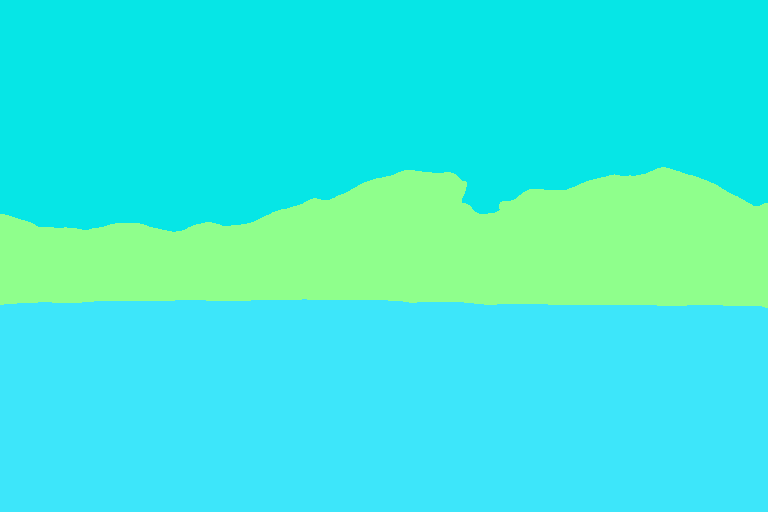

In [33]:
seg

In [46]:
np.unique(seg)

array([  6,  61, 140, 143, 230, 250, 255], dtype=uint8)

In [52]:
seg[0,0,:]

array([  6, 230, 230], dtype=uint8)

: 